# Introduction
In this notebook, we use the `parallel` submodule of `IPython` for distributing an `OpenTURNSPythonFunction`. This is a very interesting alternative to the `otdistfunc` module that enables a better handling of errors as well as load-balancing. Note that it does not manage third-party files and execution directories though (parsed input files are often needed for running third-party softwares). But this can be handled manually using the `tempfile` module.

In [1]:
try:
    from ipyparallel import Client
    from ipyparallel.error import TimeoutError, CompositeError
    from ipyparallel.client.view import View
except ImportError:
    from Ipython.parallel import Client
    from Ipython.parallel.error import TimeoutError, CompositeError
    from Ipython.parallel.client.view import View
from IPython.core.display import clear_output
import openturns as ot
from datetime import timedelta
import sys

In case you've never never heard about IPython, check the [official website](http://www.ipython.org "IPython") as well as the following presentation of Fernando Perez.

In [2]:
from IPython.display import VimeoVideo
VimeoVideo("63250251")

# Definition of the `OpenTURNSIPythonParallelFunction`
This is the main contribution of that notebook. This class basically binds the `OpenTURNSPythonFunction` to the IPython parallel computing capabilities.

Please be advised this is a raw implementation whose unique purpose is to demonstrate the power of `IPython.parallel` for expensive-to-evaluate `NumericalMathFunction`'s.

In [3]:
class OpenTURNSIPythonParallelFunction(ot.OpenTURNSPythonFunction):
    """Distributed Python function using IPython.parallel.

    Parameters
    ----------
    n : int
        The input dimension.

    p : int
        The output dimension.

    func : callable
        A Python function implementing the calculation for a single
        vector (aka NumericalPoint) input X.

    view : IPython.parallel.DirectView or IPython.parallel.LoadBalancedView
        A view of your IPython engines (either direct or load-balanced).

    verbose : boolean, optional
        Give information on progress of jobs or don't.

    on_error : string, optional
        What should be done in case an engine bumps into an error:
          - 'abort' prints the first error an engine has bumped into and
            aborts the whole stack;
          - 'ignore' excepts any error the engines could bump into and
            fills the outputs with NaN's.

    interval : float, optional
        The time interval in-between two checks of jobs status.
        This basically depends on the job duration.
    """

    def __init__(self, n, p, func, view, verbose=True, on_error='abort', interval=1.):

        assert callable(func)
        assert isinstance(view, View)
        assert on_error in ['abort', 'ignore']
        super(OpenTURNSIPythonParallelFunction, self).__init__(n, p)
        self._func = func
        self._view = view
        self._verbose = bool(verbose)
        self._on_error = on_error
        self._interval = float(interval)

    def _exec(self, X):

        return self._exec_sample([X])[0]

    def _exec_sample(self, X):

        jobs = self._view.map_async(self._func, X)

        Y, done = [None] * len(jobs), []
        while not jobs.ready():
            jobs.wait(self._interval)
            if self._verbose:
                clear_output(wait=True)
                print("%4i/%i tasks finished after %s."
                       % (jobs.progress, len(jobs),
                          timedelta(0., jobs.elapsed)))
                sys.stdout.flush()
            for i in range(len(jobs)):
                if i in done:
                    continue
                try:
                    Y[i] = jobs[i]
                    done.append(i)
                except TimeoutError:
                    break
                except CompositeError as err:
                    Y.append([np.nan] * self.getOutputDimension())
                    done.append(i)
                    if self._on_error == 'abort':
                        try:
                            jobs.abort()
                        except AssertionError:
                            pass
                        if float(ot.__version__) < 1.3:
                            err.print_exception()
                        raise err
                    else:
                        pass

        if self._verbose:
            print('\ndone')

        return Y

We also declare a convenience function that will instanciate the final `NumericalMathFunction` from our overloaded `OpenTURNSIPythonParallelFunction` instance as it is already done for the `OpenTURNSPythonFunction` (see `ot.PythonFunction`) or the `OpenTURNSDistributedPythonFunction` (see `otdistfunc.DistributedPythonFunction`).

In [4]:
def IPythonParallelFunction(*args, **kwargs):
    __doc__ = OpenTURNSIPythonParallelFunction.__doc__

    return ot.NumericalMathFunction(OpenTURNSIPythonParallelFunction(*args, **kwargs))

Note that using a decorator here would be a lot more pythonic.

# Practice
## Cluster configuration
We first need to bind to the cluster we have ignited before running this notebook using either:
   - the cluster tab in the main menu of the IPython Notebook,
   - the `ipcluster` shell command.

For more information on the configuration of IPython clusters refer to the [official documentation](http://ipython.org/ipython-doc/dev/parallel/ "IPython.parallel official doc").

Anyhow, IPython will create a default profile (called 'default'!) so that the following should work on any fresh install of IPython. This uses localhost as a cluster and the maximum allocatable number of engines is set equal to the number of CPUs you have.

In [5]:
client = Client(profile='default')
d_view = client.direct_view()
lb_view = client.load_balanced_view()

`d_view` is a direct view of all the engines in the cluster. This can be used for executing statements in parallel on all the engines that are designated by this view (note the direct_view method of the Client object takes a `target` keyword argument that allows you to select a subset of your engines).

`lb_view` is a load-balanced view of all the engines in the cluster. It features a job manager that will distribute the workload over the engines. This is a very interesting feature in case your jobs and/or the nodes of your cluster are heterogeneous.

## Function declaration

We first need to synchronize the dependencies of our Python function over the cluster's engines. For this we use the `sync_imports` method of our direct view.

In [6]:
with d_view.sync_imports():
    from math import sin
    from time import sleep
    import numpy as np

importing sin from math on engine(s)
importing sleep from time on engine(s)
importing numpy on engine(s)


Then, we define our Python function which is responsible for calculating a single vector output $Y$ from a single vector input $X$ (say $f: X \mapsto Y$).

**NB:** *Just don't forget that IPython `"engines"` hosted on a same host share the same execution directory. Hence if you plan to parse template file and execute third-party softwares using (*e.g.* the `subprocess` module) you'd better create and cd to your own temporary execution directories using the `tempfile` module.*

In [7]:
def foo_implementation(X):
    """This is the function we want to distribute over our clients."""
    Y = [sin(X[1]) / X[0]]
    sleep(2.) # Say it takes time to run...
    return Y

We eventually turn this function into an `OpenTURNSIPythonParallelFunction` and then into a `NumericalMathFunction` using the convenience function declared above.

In [8]:
foo = IPythonParallelFunction(n=2, p=1, func=foo_implementation, view=lb_view)

## Basic usage

In [9]:
distribution = ot.ComposedDistribution([ot.Uniform(1., 5.)] * 2)
some_random_X = distribution.getSample(10)

In [10]:
foo(some_random_X)

  10/10 tasks finished after 0:00:06.456376.

done


class=NumericalSample name=Unnamed description=[y0] implementation=class=NumericalSampleImplementation name=Unnamed size=10 dimension=1 data=[class=NumericalPoint name=Unnamed dimension=1 values=[-0.186482],class=NumericalPoint name=Unnamed dimension=1 values=[0.126091],class=NumericalPoint name=Unnamed dimension=1 values=[0.390898],class=NumericalPoint name=Unnamed dimension=1 values=[-0.639416],class=NumericalPoint name=Unnamed dimension=1 values=[-0.412077],class=NumericalPoint name=Unnamed dimension=1 values=[0.168136],class=NumericalPoint name=Unnamed dimension=1 values=[-0.213551],class=NumericalPoint name=Unnamed dimension=1 values=[-0.301883],class=NumericalPoint name=Unnamed dimension=1 values=[-0.448524],class=NumericalPoint name=Unnamed dimension=1 values=[-0.424201]]

It rocks! Doesn't it?

**NB:** By the way, note that beautiful HTML rendering of the `NumericalSample` due to the recent implementation of its `_repr_html_` method. Let's do more of these for the other OpenTURNS objects (`_repr_latex_` might also be more relevant for mathematical objects such as `Distribution`'s and `NumericalMathFunction`'s).

## You asked for debug? They thought about it!
Well this is still a bit tricky to trigger, but IPython developpers made it possible to debug the traceback of the last error met by an engine. And I guess this is still work in progress, so this could be improved in the next future!...

Assume we divide by zero... That's bad!...

In [11]:
foo([0., 1.])

   1/1 tasks finished after 0:00:00.064422.


CompositeError: one or more exceptions from call to method: foo_implementation
[1:apply]: ZeroDivisionError: float division by zero

RuntimeError: InternalException : Python exception: CompositeError

As you can see in the traceback (which is now printed in openturns 1.3! ;-)), the `IPython.parallel` module triggered a `CompositeError` that features all the errors met by the engines with headers that look like this: `[%d:apply]`. The integer in front of the column within the brackets is the number of the engine that raised the error detailed after. In the following I assume engine 2 failed.

Now there are two options.

First, if you are running a local cluster, you can launch an IPython qtconsole on the engine that raised the error:

In [13]:
%%px --target=1
%qtconsole

/home/dubourg/anaconda/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


and then trigger the debugger in that qtconsole using the `%debug` magic. See:

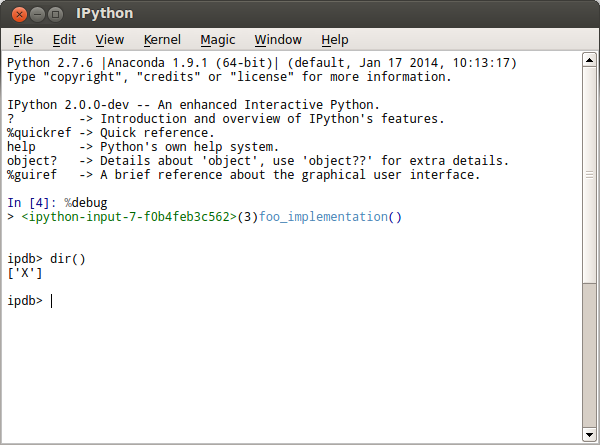

In [14]:
from IPython.display import Image
Image('OpenTURNSIPythonParallelFunction_local_qtconsole.png')

Second, in the more practical case where your engines are remote, you can ask IPython to tell you how to connect an IPython app (console or qtconsole) to the session ran by the engine. See:

In [16]:
from ipyparallel import bind_kernel
bind_kernel()

In [17]:
%%px --target=1
import socket
print('The targeted engine is running on host: %s\n' % socket.gethostname())
%connect_info

The targeted engine is running on host: maybach-l64

{
  "stdin_port": 42383, 
  "ip": "127.0.0.1", 
  "control_port": 54426, 
  "hb_port": 57028, 
  "signature_scheme": "hmac-sha256", 
  "key": "db7d34cc-372b-40ed-8fd7-b581b9439d7a", 
  "shell_port": 37302, 
  "transport": "tcp", 
  "iopub_port": 48654
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing kernel-3246.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


Then you just need to ssh yourself to the remote host where the engine is running and connect to this engine using the command returned above by `%connect_info`. Once you are in this IPython session, just issue a `%debug` in order to enter the post-mortem mode.

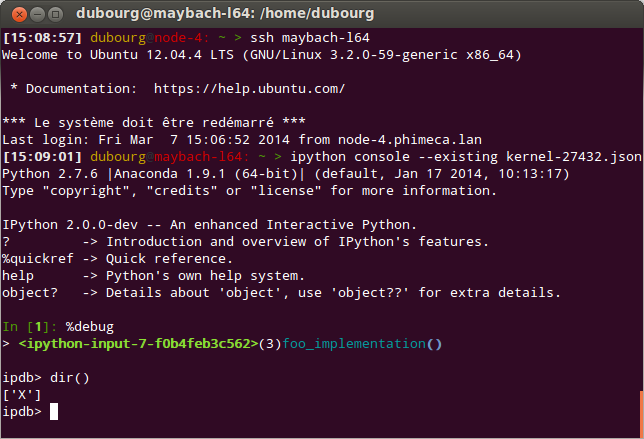

In [18]:
from IPython.display import Image
Image('OpenTURNSIPythonParallelFunction_remote_console.png')

Happy hacking with IPython!